In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import cv2
import os
import time
import math
import main_functions as main

In [3]:
def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()

In [4]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0

# SLP Linear

In [5]:
def get_mini_batch(im_train, label_train, batch_size):
    ## For ease of batching
    im_swp = np.swapaxes(im_train,0,1)
    lab_swp = np.swapaxes(label_train,0,1)
    
    ## One hot encoding
    oh_lab_swp = []
    for lab in lab_swp:
        oh = np.zeros(10)
        oh[lab] = 1
        oh_lab_swp.append(oh)
    
    seed = 527
    np.random.seed(seed)
    np.random.shuffle(im_swp)
    np.random.seed(seed)
    np.random.shuffle(oh_lab_swp)
    
    mini_batch_x = np.array(np.array_split(im_swp,batch_size))#.reshape((-1,196,32))
    mini_batch_y = np.array(np.array_split(oh_lab_swp,batch_size))#.reshape((-1,10,32))
    
    return mini_batch_x,mini_batch_y

In [6]:
def fc(x, w, b):
    if len(x.shape) > 1:
        x = x.flatten()
    y = np.dot(w,x) + b
    
    return y

In [7]:
def loss_euclidian(y_tilde, y):
    l = np.linalg.norm(y_tilde-y)**2
    dl_dy = 2*(y_tilde-y)
    
    return l, dl_dy

In [8]:
def fc_backward(dl_dy, x, w, b, y):
    dl_dx = np.dot(w.T,dl_dy)
    dl_dw = np.outer(dl_dy,x)
    dl_db = dl_dy

    return dl_dx, dl_dw, dl_db

In [9]:
def train_slp_linear(mini_batch_x, mini_batch_y):
    batch_size,batches,size_img = mini_batch_x.shape
    n = 10
    m = size_img
    lr = 1e-4
    dr = 0.9
    w = np.random.normal(0, 1, size=(n,m))
    b = np.zeros((n))
    k = 0

    for itr in range(10000):
        if itr % 1000 == 0:
            lr *= dr

        dl_dw = 0
        dl_db = 0

        for i in range(batch_size):
            x = mini_batch_x[:,k][i]
            y = mini_batch_y[:,k][i]
            
            y_tilde = fc(x, w, b)
            l,dl_dy = loss_euclidian(y_tilde, y)
            dl_dx, dl_dw_n, dl_db_n = fc_backward(dl_dy, x, w, b, y)

            dl_dw += dl_dw_n
            dl_db += dl_db_n

        k += 1
        if k >= batches:
            k = 0

        w -= (lr * dl_dw)
        b -= (lr * dl_db)
        
    return w,b

In [10]:
#main.main_slp_linear()

# SLP 

In [11]:
def loss_cross_entropy_softmax(x, y):
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x))

    l = -1 * (np.sum(y*np.log(1e-9 + softmax(x))) / len(y))
    dl_dy = softmax(x) - y
    
    return l, dl_dy

In [12]:
def train_slp(mini_batch_x, mini_batch_y):
    batch_size,batches,size_img = mini_batch_x.shape
    n = 10
    m = size_img
    lr = 1e-3
    dr = 0.9
    w = np.random.normal(0, 0.5, size=(n,m))
    b = np.zeros((n))
    k = 0

    for itr in range(10000):
        if itr % 1000 == 0:
            lr *= dr

        dl_dw = 0
        dl_db = 0

        for i in range(batch_size):
            x = mini_batch_x[:,k][i]
            y = mini_batch_y[:,k][i]
            
            fc_out = fc(x, w, b)
            l,dl_dy = loss_cross_entropy_softmax(fc_out, y)
            dl_dx, dl_dw_n, dl_db_n = fc_backward(dl_dy, x, w, b, y)

            dl_dw += dl_dw_n
            dl_db += dl_db_n

        k += 1
        if k >= batches:
            k = 0

        w -= (lr * dl_dw)
        b -= (lr * dl_db)
        
    return w,b

In [13]:
#main.main_slp()

# MLP

In [14]:
def frelu(x):
    return np.maximum(0,x)

In [15]:
def relu(x):
    return np.maximum(x*1e-2,x)

In [16]:
def frelu_backward(dl_dy, x, y):
    dl_dx = (dl_dy > 0).astype(int)
    return np.where(dl_dx==0, 0.0, dl_dx)

In [17]:
def relu_backward(dl_dy, x, y):
    dl_dx = (dl_dy > 0).astype(int)
    return np.where(dl_dx==0, 0.01, dl_dx)

In [18]:
mini_batch_x,mini_batch_y = get_mini_batch(im_train, label_train, batch_size)

In [19]:
import time as t

In [20]:
batch_size,batches,size_img = mini_batch_x.shape
n = 10
m = size_img
lr = 1e-3
dr = 0.9
w1 = np.random.normal(0, 0.5, size=(30,196))
w2 = np.random.normal(0, 0.5, size=(10,30))
b1 = np.zeros((30))
b2 = np.zeros((10))
k = 0
_ = None

st = t.time()

for itr in range(60000):

    if itr % 1000 == 0: 
        lr *= dr

    if itr % 10000 == 0:
        end = t.time()
        print(end-st)
        print(itr)

    dl_dw_1 = 0
    dl_dw_2 = 0
    dl_db_1 = 0
    dl_db_2 = 0

    for i in range(batch_size):
        x = mini_batch_x[:,k][i]
        y = mini_batch_y[:,k][i]
        
        ## Forward
        fc_1 = fc(x, w1, b1)
        relu_ = relu(fc_1)
        fc_2 = fc(relu_, w2, b2)
        l,dl_dy = loss_cross_entropy_softmax(fc_2, y)
        
        ## Backward
        dl_dx_2, dl_dw_n_2, dl_db_n_2 = fc_backward(dl_dy, relu_, w2, _, _)
        dl_dx_relu = relu_backward(dl_dx_2, _, _)
        dl_dx_1, dl_dw_n_1, dl_db_n_1 = fc_backward(dl_dx_relu, x, w1, _, _)

        dl_dw_1 += dl_dw_n_1
        dl_db_1 += dl_db_n_1
        dl_dw_2 += dl_dw_n_2
        dl_db_2 += dl_db_n_2

    k += 1
    if k >= batches:
        k = 0

    w1 -= (lr * dl_dw_1)
    b1 -= (lr * dl_db_1)
    w2 -= (lr * dl_dw_2)
    b2 -= (lr * dl_db_2)


0.0
0
30.383376121520996
10000
60.88578200340271
20000
91.54217576980591
30000
122.00301933288574
40000
152.1931619644165
50000


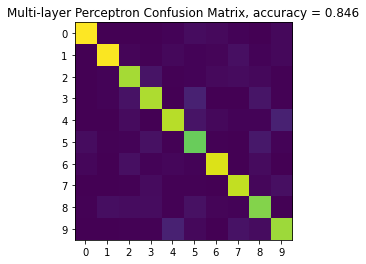

In [21]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
#w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]]
    pred1 = fc(x, w1, b1)
    pred2 = relu(pred1)
    y = fc(pred2, w2, b2)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')